<a href="https://colab.research.google.com/github/JheanmarcoOscanoa/Laboratorio-10/blob/main/Laboratorio_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 10: ANÁLISIS DE CONGLOMERADOS

**Autor:** Jheanmarco Oscanoa Vargas  
**Curso:** Minería de Datos  
**Institución:** TECSUP  
**Semana:** 10  

---

## Parte a) Preprocesamiento

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### a.0: Definición de funciones de utilidad

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

def load_and_drop(path, cols_to_drop):
    """Carga CSV y elimina columnas no deseadas."""
    df = pd.read_csv(path)
    return df.drop(columns=cols_to_drop).reset_index(drop=True)

def analyze_missing(df):
    """Devuelve conteo de faltantes por columna."""
    return df.isnull().sum()

def impute_missing(df):
    """Imputa numéricos por la mediana y categóricos por la moda."""
    df = df.copy()
    num = df.select_dtypes(include=[np.number]).columns
    cat = df.select_dtypes(include=['object','category']).columns
    for c in num: df[c].fillna(df[c].median(), inplace=True)
    for c in cat: df[c].fillna(df[c].mode()[0], inplace=True)
    return df

def remove_outliers_iqr(df):
    """Elimina filas con outliers univariados usando IQR."""
    df = df.copy()
    num = df.select_dtypes(include=[np.number]).columns
    Q1, Q3 = df[num].quantile(0.25), df[num].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[num] < (Q1 - 1.5 * IQR)) | (df[num] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[mask].reset_index(drop=True)

def remove_outliers_zscore(df, thresh=3):
    """Elimina filas con outliers multivariados usando Z-score."""
    df = df.copy()
    num = df.select_dtypes(include=[np.number]).columns
    z = df[num].apply(zscore)
    return df[(z.abs() < thresh).all(axis=1)].reset_index(drop=True)

def preprocess_features(df):
    """Escala numéricas y convierte categóricas a dummies."""
    num = df.select_dtypes(include=[np.number]).columns
    cat = df.select_dtypes(include=['object','category']).columns
    scaler = StandardScaler()
    df_num = pd.DataFrame(scaler.fit_transform(df[num]), columns=num, index=df.index)
    df_cat = pd.get_dummies(df[cat], drop_first=False, dtype=int)
    return df_num, df_cat


### a.1: Carga y eliminación de columnas irrelevantes

In [4]:
# a.1
# Montamos Drive y cargamos solo las columnas útiles
from google.colab import drive
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Ciclo 05/Mineria de Datos/Semana 10/vehículos.csv'
cols_irrelevantes = [
    'fabricante','modelo','transmision',
    'traccion','clase','combustible','consumo'
]

df = load_and_drop(ruta, cols_irrelevantes)
print("Dimensiones tras eliminar columnas:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones tras eliminar columnas: (36791, 12)


,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


### a.2: Análisis e imputación de valores faltantes

In [5]:
# a.2
print("Valores faltantes antes de imputar:\n", analyze_missing(df))

df = impute_missing(df)

print("\nValores faltantes luego de imputar:\n", analyze_missing(df))

Valores faltantes antes de imputar:
 year                    0
desplazamiento          2
cilindros               3
co2                     0
clase_tipo              0
traccion_tipo           0
transmision_tipo        0
combustible_tipo        0
tamano_motor_tipo       2
consumo_tipo            0
co2_tipo                0
consumo_litros_milla    0
dtype: int64

Valores faltantes luego de imputar:
 year                    0
desplazamiento          0
cilindros               0
co2                     0
clase_tipo              0
traccion_tipo           0
transmision_tipo        0
combustible_tipo        0
tamano_motor_tipo       0
consumo_tipo            0
co2_tipo                0
consumo_litros_milla    0
dtype: int64


<ipython-input-3-55f12a6d9725>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  for c in num: df[c].fillna(df[c].median(), inplace=True)
<ipython-input-3-55f12a6d9725>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

### a.3: Eliminación de outliers univariados (IQR)

In [6]:
# a.3
antes = df.shape[0]
df = remove_outliers_iqr(df)
despues = df.shape[0]
print(f"Filas eliminadas por IQR: {antes - despues}")


Filas eliminadas por IQR: 1924


### a.4: Eliminación de outliers multivariados (Z-score)

In [7]:
# a.4
antes = df.shape[0]
df = remove_outliers_zscore(df, thresh=3)
despues = df.shape[0]
print(f"Filas eliminadas por Z-score: {antes - despues}")


Filas eliminadas por Z-score: 14


### a.5: Escalamiento de variables numéricas y dummización

In [8]:
# a.5
df_num, df_cat = preprocess_features(df)

# Matriz final para clustering
X_veh = pd.concat([df_num, df_cat], axis=1)

print("Dimensiones de la matriz de características:", X_veh.shape)
X_veh.head()

Dimensiones de la matriz de características: (34853, 36)


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,-1.633364,-0.552287,-1.023028,0.640654,0.656161,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,-1.633364,0.798232,0.292798,2.257966,2.279978,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,-1.536688,-0.552287,-1.023028,0.969171,0.985999,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
3,-1.536688,0.798232,0.292798,2.257966,2.279978,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,-1.343334,0.480463,0.292798,0.969171,0.985999,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


## Parte b) Análisis de conglomerados

In [9]:
# b.0 – Definición de utilidades para K-Means
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def cluster_elbow(X, k_min=1, k_max=10, **km_kwargs):
    """Devuelve listas ks e inercias para k en [k_min…k_max]."""
    ks = list(range(k_min, k_max+1))
    inercias = []
    for k in ks:
        km = KMeans(n_clusters=k, **km_kwargs)
        km.fit(X)
        inercias.append(km.inertia_)
    return ks, inercias

def silhouette_sweep_kmeans(X, k_min=2, k_max=10, **km_kwargs):
    """Devuelve listas ks y silhouette_scores para k en [k_min…k_max]."""
    ks = list(range(k_min, k_max+1))
    scores = []
    for k in ks:
        km = KMeans(n_clusters=k, **km_kwargs)
        labels = km.fit_predict(X)
        scores.append(silhouette_score(X, labels))
    return ks, scores


### b.1 Gráfico de codo (inercia vs k)

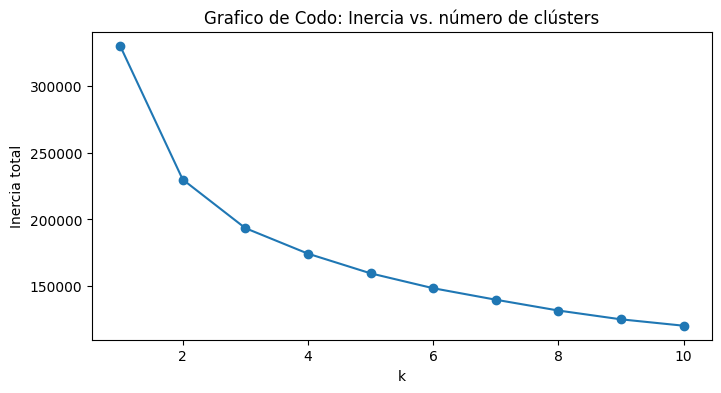

In [16]:
# b.1 Método del codo: inercia para k=1..10
ks, inercias = cluster_elbow(
    X_veh,
    k_min=1,
    k_max=10,
    n_init=25,
    random_state=123
)

plt.figure(figsize=(8,4))
plt.plot(ks, inercias, marker='o')
plt.title("Grafico de Codo: Inercia vs. número de clústers")
plt.xlabel("k")
plt.ylabel("Inercia total")
plt.show()

### b.2 Barrido de Silhouette (Silhouette vs k)

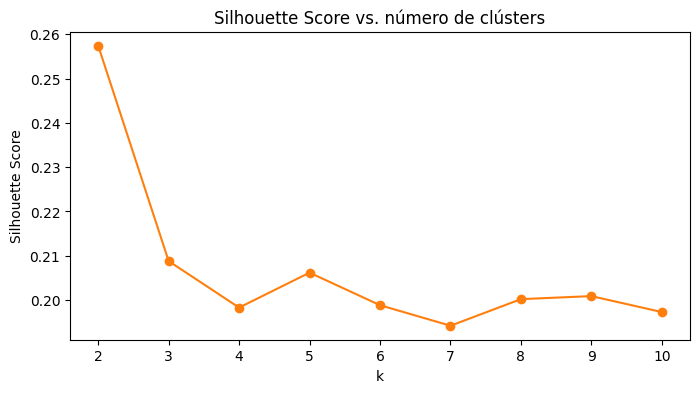

In [11]:
# b.2 Sweep de Silhouette para k=2..10
ks2, sil_scores = silhouette_sweep_kmeans(
    X_veh,
    k_min=2,
    k_max=10,
    n_init=25,
    random_state=123
)

plt.figure(figsize=(8,4))
plt.plot(ks2, sil_scores, marker='o', color='C1')
plt.title("Silhouette Score vs. número de clústers")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

### b.3 Ajuste final de K-Means y resumen de conglomerados

In [15]:
# b.3 Ajuste final de K-Means y resumen de conglomerados

from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# — 1) Ajustamos K-Means con el k óptimo
k_opt = 2  # o el valor que hayas elegido según b.1/b.2
km = KMeans(n_clusters=k_opt, n_init=25, random_state=123)
labels = km.fit_predict(X_veh)

# — 2) Asignamos etiquetas al DataFrame original
df['Cluster_KMeans'] = labels

# — 3) Mostramos el tamaño de cada clúster
print("Tamaños de clústeres:")
print(pd.Series(labels).value_counts().sort_index())

# — 4) Recomputamos las columnas categóricas originales
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Columnas categóricas usadas para el resumen:", cat_cols)

# — 5) Definimos (o reutilizamos) la función de resumen
def summarize_cluster(df, labels, cat_cols):
    resumen = []
    for c in np.unique(labels):
        sub = df[labels == c]
        # moda de originales categóricas
        modo = {col: sub[col].mode()[0] for col in cat_cols}
        # media de numéricas
        medias = sub.select_dtypes(include=[np.number]).mean().to_dict()
        resumen.append({'cluster': c, **modo, **medias})
    return pd.DataFrame(resumen).set_index('cluster')

# — 6) Generamos y mostramos el resumen
resumen = summarize_cluster(df, labels, cat_cols)
display(resumen)


Tamaños de clústeres:
0    17829
1    17024
Name: count, dtype: int64
Columnas categóricas usadas para el resumen: ['clase_tipo', 'traccion_tipo', 'transmision_tipo', 'combustible_tipo', 'tamano_motor_tipo', 'consumo_tipo', 'co2_tipo']


,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,year,desplazamiento,cilindros,co2,consumo_litros_milla,Cluster_KMeans
cluster,,,,,,,,,,,,,
0,Coches pequeños,dos,Automatica,Normal,muy pequeño,muy bajo,muy bajo,2001.216109,2.253110,4.378653,384.534811,0.16351,0.0
1,Camionetas,dos,Automatica,Normal,grande,moderado,moderado,2000.558917,4.181849,6.786889,537.084795,0.22795,1.0


Conclusión:
El método k-means ha separado esencialmente dos “tipos” de vehículo:

Autos ligeros y eficientes (cluster 0), con baja cilindrada, muy bajo consumo y emisiones.

SUVs/camionetas (cluster 1), con mayor tamaño de motor, más cilindros y consumo/emisiones sensiblemente superiores.

## Parte c)  Principales medidas de evaluación interna

### c.0 Definición de funciones de evaluación

In [21]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    homogeneity_completeness_v_measure
)

def evaluate_internal(X, labels):
    """Imprime las métricas internas: Silhouette y Davies–Bouldin."""
    print("Silhouette Score:     ", silhouette_score(X, labels))
    print("Davies–Bouldin Score: ", davies_bouldin_score(X, labels))

def evaluate_external(df, labels, col_true):
    """
    Imprime las métricas externas comparando 'labels' vs. df[col_true]:
      - Adjusted Rand
      - Homogeneity
      - Completeness
      - V-measure
    """
    ari = adjusted_rand_score(df[col_true], labels)
    h, c, v = homogeneity_completeness_v_measure(df[col_true], labels)
    print(f"Adjusted Rand Index:  {ari:.3f}")
    print(f"Homogeneity:          {h:.3f}")
    print(f"Completeness:         {c:.3f}")
    print(f"V-measure:            {v:.3f}")

### c.1 Evaluación interna del clustering elegido

In [22]:
# c.1 – Evaluación interna para el clustering con k_opt de la parte b)
print(">> Evaluación interna (k_opt =", k_opt, ")")
evaluate_internal(X_veh, labels)

>> Evaluación interna (k_opt = 2 )
Silhouette Score:      0.2574307324687141
Davies–Bouldin Score:  1.495746950641784


### c.2 Evaluación externa con k=8 usando ‘clase_tipo’ como referencia

In [23]:
# c.2 – Evaluación externa con k=8 vs. 'clase_tipo'
from sklearn.cluster import KMeans

k_ext = 8
km8 = KMeans(n_clusters=k_ext, n_init=25, random_state=123)
labels8 = km8.fit_predict(X_veh)

df['Cluster_KMeans_8'] = labels8

print(">> Evaluación externa (k =", k_ext, ") vs. 'clase_tipo'")
evaluate_external(df, labels8, 'clase_tipo')


>> Evaluación externa (k = 8 ) vs. 'clase_tipo'
Adjusted Rand Index:  0.067
Homogeneity:          0.157
Completeness:         0.141
V-measure:            0.149
